# Trabalho Prático 4 Grupo 24

Gabriel Antunes a101101<br>
Guilherme Pinho a105533

## Problema 1

No contexto do sistema de travagem ABS (“Anti-Lock Breaking System”), pretende-se construir um autómato híbrido que descreva o sistema e que  possa ser usado para verificar as suas propriedades dinâmicas.

Objetivo:


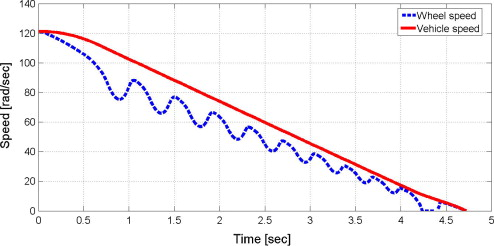


Velocidade do veículo deve ser estritamente decrescente

In [31]:
from pysmt.shortcuts import *
from pysmt.typing import *
import matplotlib.pyplot as plt

In [32]:
# Os estados possíveis que temos de considerar são:
# Start - 0 
# Free - 1
# Stopping - 2 
# Blocked - 3
# Stopped - 4

MODE = {0 : "Start", 1 : "Free", 2 : "Stopping", 3 : "Blocked", 4 : "Stopped"}

def declare(i):
    state = {}
    state["state"] = Symbol("state"+str(i), types.INT)   # Representa o estado em que o autómato está num determinado momento
    state["V"] = Symbol("V"+str(i), types.REAL)           # Representa a velocidade do corpo do veículo em relação ao solo
    state["v"] = Symbol("v"+str(i), types.REAL)           # Representa a velocidade das rodas em relação ao solo
    state["t"] = Symbol("t"+str(i), types.REAL)           # Representa a contagem do tempo durante toda a operação do sistema
    state["timer"] = Symbol("timer"+str(i), types.REAL)   # Representa a contagem do tempo num determinado estado que tenha um limite de tempo de operação
    return state

In [33]:
def init(state, V0):
    return And (Equals(state["t"], Real(0)),
                Equals(state["V"], Real(V0)),        # V0 é o input do problema e representa a velocidade do veículo no momento da ativação dos sistema
                Equals(state["v"], Real(V0)),         
                Equals(state["state"], Int(0)),      # O estado 0 representa o estado "Start"
                Equals(state["timer"], Real(0))
                )

In [34]:
def trans(curr, prox, VelPrecision, intervaloTempoB, intervaloTempoF, fTravagemAlta, fTravagemBaixa, atrito, atritoAr, peso, V0, delta_t):
   
   equalstt = Equals(curr["t"], prox["t"])
   equalsVV = Equals(curr["V"], prox["V"])
   equalsvv = Equals(curr["v"], prox["v"])

   # Untimed (reprentam as transições da parte discreta do autómato híbrido)

   TStartFree = And(Equals(curr["state"], Int(0)),
                    Equals(prox["state"], Int(1)),
                    Equals(curr["timer"], Real(0)),
                    Equals(prox["timer"], Real(0)),
                    equalstt,
                    equalsVV,
                    equalsvv)
    
   TFreeStopping = And(Equals(curr["state"], Int(1)),
                       Equals(prox["state"], Int(2)),
                       GT(curr["V"], Real(VelPrecision)),
                       GT(curr["v"], Real(VelPrecision)),
                       Or(GE(curr["timer"], Real(intervaloTempoF)),
                          GE(curr["V"] - curr["v"], Real(VelPrecision))),
                       equalstt,
                       equalsVV,
                       equalsvv)
    
   TStoppingBlocked = And(Equals(curr["state"], Int(2)),
                           Equals(prox["state"], Int(3)),
                           LT(curr["V"] - curr["v"], Real(0.2)), #
                           Equals(curr["timer"], Real(0)),
                           Equals(prox["timer"], Real(0)),
                           GT(curr["v"], Real(VelPrecision)),
                           equalstt,
                           equalsVV,
                           equalsvv)
    
   TBlockedFree = And(Equals(curr["state"], Int(3)),
                        Equals(prox["state"], Int(1)),
                        GT(curr["V"], Real(VelPrecision)),
                        GT(curr["v"], Real(VelPrecision)),
                        GE(curr["timer"], Real(intervaloTempoB)), #
                        Equals(prox["timer"], Real(0)),
                        equalstt,
                        equalsVV,
                        equalsvv)
   
   TAnyStopped = And(Or(Equals(curr["state"], Int(1)),
                        Equals(curr["state"], Int(2)),
                        Equals(curr["state"], Int(3))),
                     Equals(prox["state"], Int(4)),
                     LE(curr["V"], Real(VelPrecision)),
                     LE(curr["v"], Real(VelPrecision)),
                     GE(prox["V"], Real(0)),
                     GE(prox["v"], Real(0)),
                     equalstt,
                     equalsVV,
                     equalsvv)
   
   untimed = Or(TStartFree, TFreeStopping, TStoppingBlocked, TBlockedFree, TAnyStopped)

   # Timed (representam as transições da parte contínua do autómato híbrido)

   TFree = And(Equals(curr["state"], Int(1)),
               Equals(prox["state"], Int(1)),
               Equals(prox["timer"], curr["timer"] + delta_t),
               Equals(prox["t"], curr["t"] + delta_t),
               LT(prox["timer"], Real(intervaloTempoF) + delta_t),
               GT(curr["v"], Real(VelPrecision)),

               Equals(prox["V"], curr["V"] + (Real(-fTravagemBaixa) * (curr["V"] - curr["v"]) - Real(atritoAr)) * delta_t),
               Equals(prox["v"], curr["v"] + (Real(-atrito) * Real(peso) + Real(fTravagemBaixa) * (curr["V"] - curr["v"])) * delta_t))

   TStopping = And(Equals(curr["state"], Int(2)), 
                  Equals(prox["state"], Int(2)),
                  GT(curr["V"] - curr["v"], Real(0.2)),
                  Equals(prox["timer"], curr["timer"] + delta_t),
                  Equals(prox["t"], curr["t"] + delta_t),
                  LT(prox["v"], prox["V"]),

                  Equals(prox["V"], Max(Real(0), curr["V"] + (Real(-fTravagemAlta) * (curr["V"] - curr["v"]) - Real(atritoAr)) * delta_t)),
                  Equals(prox["v"], Max(Real(0), curr["v"] + (Real(-atrito) * Real(peso) + Real(fTravagemAlta) * (curr["V"] - curr["v"])) * delta_t)))

   TBlocked = And(Equals(curr["state"], Int(3)),
                  Equals(prox["state"], Int(3)),
                  Equals(prox["timer"], curr["timer"] + delta_t),
                  Equals(prox["t"], curr["t"] + delta_t),
                  LT(prox["timer"], Real(intervaloTempoB) + delta_t),

                  Equals(prox["V"], Max(Real(0), curr["V"] + (-Real(atrito) * Real(peso) - Real(atritoAr)) * delta_t)),
                  Equals(prox["v"], Max(Real(0), curr["v"] + (-Real(atrito) * Real(peso) - Real(atritoAr)) * delta_t)))

   timed = Or(TFree, TStopping, TBlocked)

   end = And(Equals(curr["state"], Int(4)), 
            Equals(prox["state"], Int(4)),
            Equals(prox["t"], curr["t"] + delta_t),
            equalsVV,
            equalsvv)

   return Or(untimed, timed, end)


In [35]:
def print_vars(state, solver):
    for var in state:
        if state[var].get_type() == REAL:
            print(f"  {var} = {float(solver.get_py_value(state[var]))}")
        if var == "state":
            print(f"  {var} = {MODE[solver.get_py_value(state[var])]}({solver.get_py_value(state[var])})")
    
def geraTraco(declare, init, trans, atrito, atritoAr, fTravagemAlta, fTravagemBaixa, intervaloTempoB, intervaloTempoF, peso, VelPrecision, V0, k, delta_t):

    states = [declare(i) for i in range(k)]

    t=[]
    V=[]
    vr=[]

    with Solver() as solver:
        solver.add_assertion(init(states[0], V0))    
        for i in range(k - 1):
            solver.add_assertion(trans(states[i], states[i+1], VelPrecision, intervaloTempoB, intervaloTempoF, fTravagemAlta, fTravagemBaixa, atrito, atritoAr, peso, V0, delta_t))

        if solver.solve():
            print("Solver found a solution")
            for i,s in enumerate(states):
                print(f"> State {i}:")
                print_vars(s, solver)

                t.append(float(solver.get_py_value(s["t"])))
                V.append(float(solver.get_py_value(s["V"])))
                vr.append(float(solver.get_py_value(s["v"])))

        else:
            print("Solver failed to find a solution")
            print("> Not feasible.")

    fig ,ax = plt.subplots()

    line1, = ax.plot(t, V, color="red", linestyle="solid", label="VVeiculo")
    line2, = ax.plot(t, vr, color="blue", linestyle="dashed", label="vRodas")

    ax.set_xlabel("Tempo (t)")
    ax.set_ylabel("velocidade (v)")

    ax.legend([line1, line2], ["VVeiculo", "vRodas"])

    plt.show()


Solver found a solution
> State 0:
  state = Start(0)
  V = 200.0
  v = 200.0
  t = 0.0
  timer = 0.0
> State 1:
  state = Free(1)
  V = 200.0
  v = 200.0
  t = 0.0
  timer = 0.0
> State 2:
  state = Free(1)
  V = 199.99975
  v = 190.0
  t = 0.25
  timer = 0.25
> State 3:
  state = Free(1)
  V = 189.99975
  v = 189.99975
  t = 0.5
  timer = 0.5
> State 4:
  state = Stopping(2)
  V = 189.99975
  v = 189.99975
  t = 0.5
  timer = 0.0
> State 5:
  state = Blocked(3)
  V = 189.99975
  v = 189.99975
  t = 0.5
  timer = 0.0
> State 6:
  state = Blocked(3)
  V = 179.9995
  v = 179.9995
  t = 0.75
  timer = 0.25
> State 7:
  state = Blocked(3)
  V = 169.99925
  v = 169.99925
  t = 1.0
  timer = 0.5
> State 8:
  state = Free(1)
  V = 169.99925
  v = 169.99925
  t = 1.0
  timer = 0.0
> State 9:
  state = Free(1)
  V = 169.999
  v = 159.99925
  t = 1.25
  timer = 0.25
> State 10:
  state = Free(1)
  V = 159.999
  v = 159.999
  t = 1.5
  timer = 0.5
> State 11:
  state = Stopping(2)
  V = 159.999


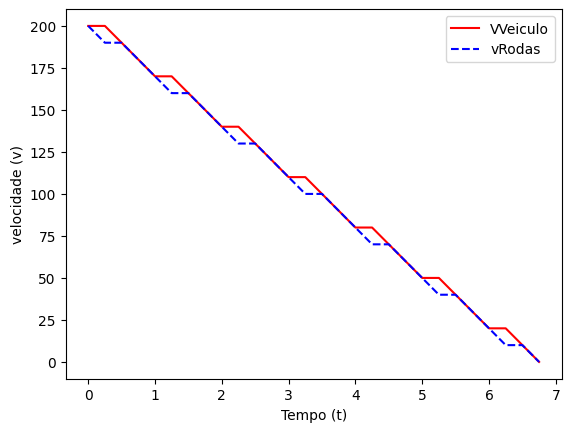

In [36]:
# Parâmetros do problema

atrito = 0.02
atritoAr = 0.001

peso = 2000

fTravagemAlta = atrito * peso
fTravagemBaixa = atrito * peso * 0.1

intervaloTempoB = 0.5
intervaloTempoF = 0.5
delta_t = 0.25

V0 = 200

VelPrecision = 0.1
k = 49

geraTraco(declare, init, trans, atrito, atritoAr, fTravagemAlta, fTravagemBaixa, intervaloTempoB, intervaloTempoF, peso, VelPrecision, V0, k, delta_t)

Alinea d)

In [37]:
def bmc_alwaysi(declare,init,trans,inv, t, K):
    
    with Solver() as solver:
        states = [declare(i) for i in range(K)]
        solver.add_assertion(init(states[0], V0))

        for k in range(K):
            if k>0:
                solver.add_assertion(trans(states[k-1], states[k], VelPrecision, intervaloTempoB, intervaloTempoF, fTravagemAlta, fTravagemBaixa, atrito, atritoAr, peso, V0, delta_t))

            solver.push()
            solver.add_assertion(Not(inv(states[k], t)))

            if solver.solve():
                print(f"> Invariant does not hold for {k+1} first states. Counter-example:")
                for i,s in enumerate(states[:k+1]):
                    print(f"> State {i}:")
                    print_vars(s, solver)
                return
            else:
                if k==K-1:
                    print(f"> Invariant holds for the first {K} states.")
                else:
                    solver.pop()

Condição i:

    ”o veículo imobiliza-se completamente em menos de t segundos” 

In [38]:
def beforeTSec(curr, t):
    return And(Implies(Equals(curr["state"], Int(4)), LE(curr["t"], Real(t))), # Verifica se quando chega ao estado 4 (Veículo imobilizado), o tempo decorrido é menor ou igual a t
              Implies(GE(curr["t"], Real(t)), Equals(curr["V"], Real(0)))) # Verifica se quando o tempo decorrido ultrapassou t, a velocidade do veículo é 0 

t = 4
# t = 4 Por exemplo não resultaria

bmc_alwaysi(declare, init, trans, beforeTSec, t, 49)

> Invariant does not hold for 29 first states. Counter-example:
> State 0:
  state = Start(0)
  V = 200.0
  v = 200.0
  t = 0.0
  timer = 0.0
> State 1:
  state = Free(1)
  V = 200.0
  v = 200.0
  t = 0.0
  timer = 0.0
> State 2:
  state = Free(1)
  V = 199.99975
  v = 190.0
  t = 0.25
  timer = 0.25
> State 3:
  state = Free(1)
  V = 189.99975
  v = 189.99975
  t = 0.5
  timer = 0.5
> State 4:
  state = Stopping(2)
  V = 189.99975
  v = 189.99975
  t = 0.5
  timer = 0.0
> State 5:
  state = Blocked(3)
  V = 189.99975
  v = 189.99975
  t = 0.5
  timer = 0.0
> State 6:
  state = Blocked(3)
  V = 179.9995
  v = 179.9995
  t = 0.75
  timer = 0.25
> State 7:
  state = Blocked(3)
  V = 169.99925
  v = 169.99925
  t = 1.0
  timer = 0.5
> State 8:
  state = Free(1)
  V = 169.99925
  v = 169.99925
  t = 1.0
  timer = 0.0
> State 9:
  state = Free(1)
  V = 169.999
  v = 159.99925
  t = 1.25
  timer = 0.25
> State 10:
  state = Free(1)
  V = 159.999
  v = 159.999
  t = 1.5
  timer = 0.5
> State 

Condição ii:

    “a velocidade V diminui sempre com o tempo”.

In [39]:
def bmc_alwaysii(declare,init,trans,inv, K):
    
    with Solver() as solver:
        states = [declare(i) for i in range(K)]
        solver.add_assertion(init(states[0], V0))

        for k in range(K-1):
            
            solver.add_assertion(trans(states[k], states[k+1], VelPrecision, intervaloTempoB, intervaloTempoF, fTravagemAlta, fTravagemBaixa, atrito, atritoAr, peso, V0, delta_t))

            solver.push()
            solver.add_assertion(Not(inv(states[k], states[k+1])))

            if solver.solve():
                print(f"> Invariant does not hold for {k+1} first states. Counter-example:")
                for i,s in enumerate(states[:k+1]):
                    print(f"> State {i}:")
                    print_vars(s, solver)
                return
            else:
                if k==K - 2:
                    print(f"> Invariant holds for the first {K} states.")
                else:
                    solver.pop()

In [40]:
def VStrictlyDcr(curr, prox):
    return Implies(LE(curr["t"], prox["t"]), GE(curr["V"], prox["V"]))

bmc_alwaysii(declare, init, trans, VStrictlyDcr, 50)

> Invariant holds for the first 50 states.
